# 위 용종 분류

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random
from PIL import Image

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Custom Dataset

In [4]:
class CsutomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            img_list = os.listdir(cls_dir)
            for img in img_list:
                img_dir = os.path.join(cls_dir, img)
                self.data.append((img_dir, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [5]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])
classes = ['normal', 'abnormal']

train_dataset = CsutomDataset('/Users/kimhongseok/cv_79_projects/part2/5/data/train', classes, transforms)
valid_dataset = CsutomDataset('/Users/kimhongseok/cv_79_projects/part2/5/data/val', classes, transforms)
test_dataset = CsutomDataset('/Users/kimhongseok/cv_79_projects/part2/5/data/test', classes, transforms)

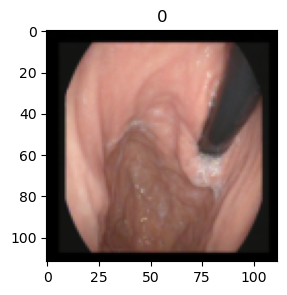

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(train_dataset[0][1])
plt.show()

In [8]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

297 41 31


In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

# Train, Eval

In [19]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    total_labels = []
    total_preds = []
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()
        
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_accuracy, train_f1

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    total_labels = []
    total_preds = []
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_accuracy, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_loss_list = []
    train_accuracy_list = []
    train_f1_list = []
    valid_loss_list = []
    valid_accuracy_list = []
    valid_f1_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy, train_f1 = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy, valid_f1 = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        train_f1_list.append(train_f1)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)
        valid_f1_list.append(valid_f1)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train F1: {train_f1}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}, Valid F1: {valid_f1}')

    return model, train_loss_list, train_accuracy_list, train_f1_list, valid_loss_list, valid_accuracy_list, valid_f1_list

# model

In [21]:
model = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes=2
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [22]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
model, train_loss_list, train_accuracy_list, train_f1_list, valid_loss_list, valid_accuracy_list, valid_f1_list = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 5.280978051821391, Train Accuracy: 0.39057239057239057, Train F1: 0.39032356843931815
Valid Loss: 2.6605809926986694, Valid Accuracy: 0.4146341463414634, Valid F1: 0.4142857142857143


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 3.4630745808283487, Train Accuracy: 0.48148148148148145, Train F1: 0.45864501467664054
Valid Loss: 2.3369261518120767, Valid Accuracy: 0.5853658536585366, Valid F1: 0.57629179331307


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.791767434279124, Train Accuracy: 0.5521885521885522, Train F1: 0.5132527448153488
Valid Loss: 3.056058633327484, Valid Accuracy: 0.5365853658536586, Valid F1: 0.5072738772928526


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.7160982827345532, Train Accuracy: 0.569023569023569, Train F1: 0.5221719457013574
Valid Loss: 2.198959743976593, Valid Accuracy: 0.5853658536585366, Valid F1: 0.5689548546691404


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.118002589046955, Train Accuracy: 0.622895622895623, Train F1: 0.5778680203045685
Valid Loss: 2.1641966700553894, Valid Accuracy: 0.6097560975609756, Valid F1: 0.5900000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.023255266745885, Train Accuracy: 0.6060606060606061, Train F1: 0.5700073008055635
Valid Loss: 2.083780807256699, Valid Accuracy: 0.6097560975609756, Valid F1: 0.5980392156862745


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.022460362315178, Train Accuracy: 0.6094276094276094, Train F1: 0.5763403836694541
Valid Loss: 1.8134714156389236, Valid Accuracy: 0.6341463414634146, Valid F1: 0.619666048237477


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.659805804491043, Train Accuracy: 0.6632996632996633, Train F1: 0.6332608910402054
Valid Loss: 1.968685907870531, Valid Accuracy: 0.6585365853658537, Valid F1: 0.6482843137254901


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.7061712441189836, Train Accuracy: 0.6531986531986532, Train F1: 0.6145918637319995
Valid Loss: 1.8134870655834674, Valid Accuracy: 0.6829268292682927, Valid F1: 0.6759878419452887


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.4689406275749206, Train Accuracy: 0.6936026936026936, Train F1: 0.6696329254727476
Valid Loss: 1.8841717809438705, Valid Accuracy: 0.6097560975609756, Valid F1: 0.5900000000000001


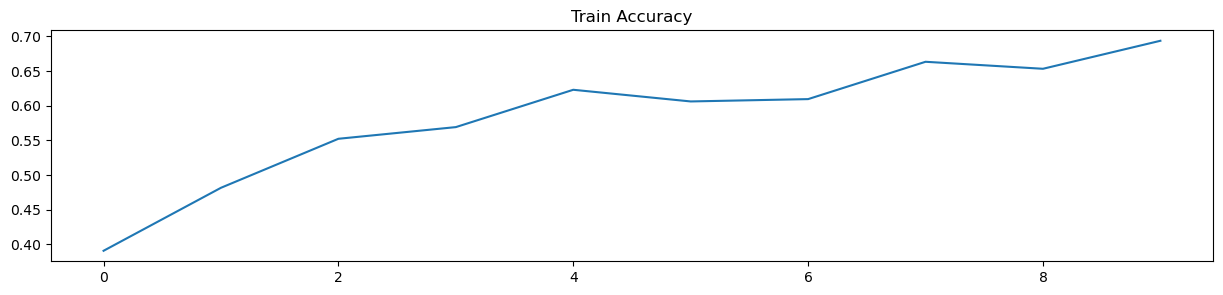

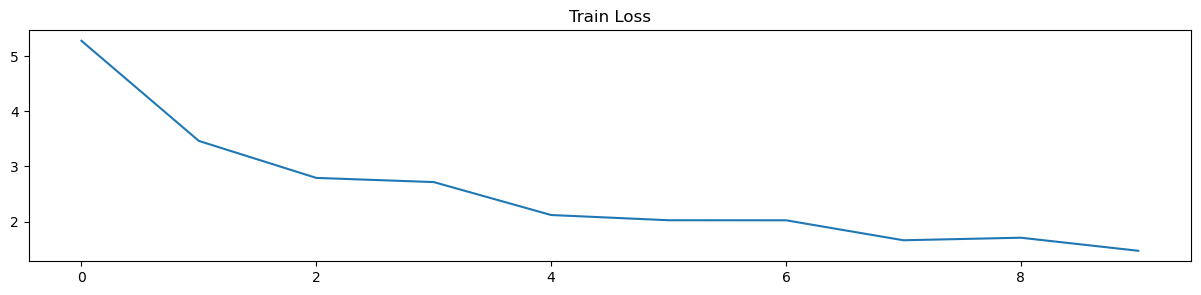

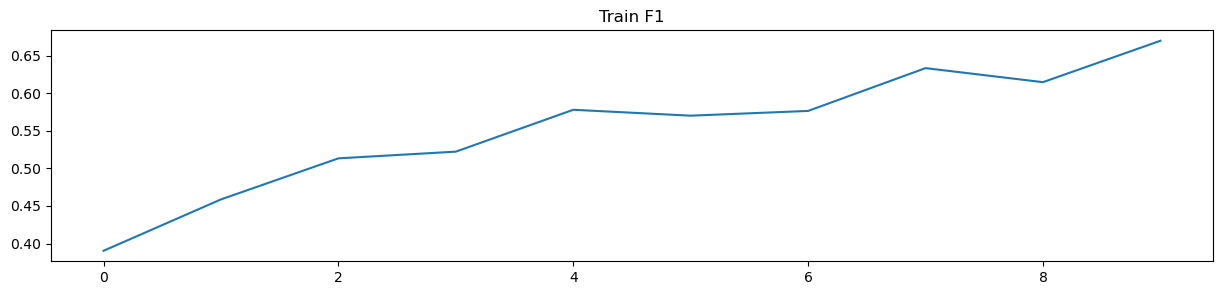

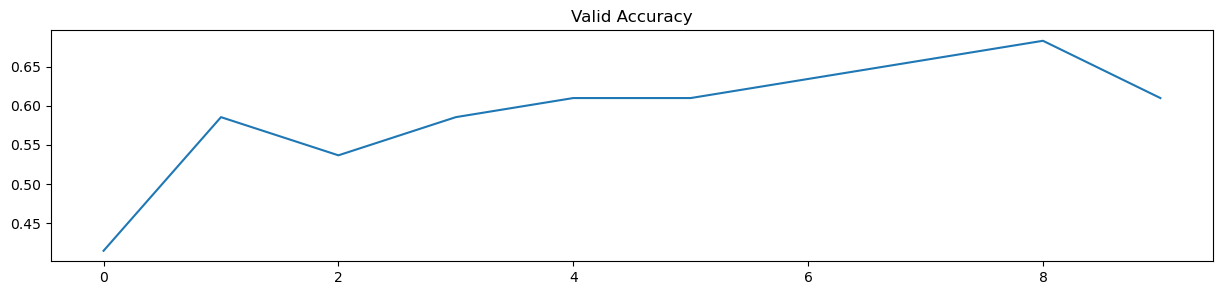

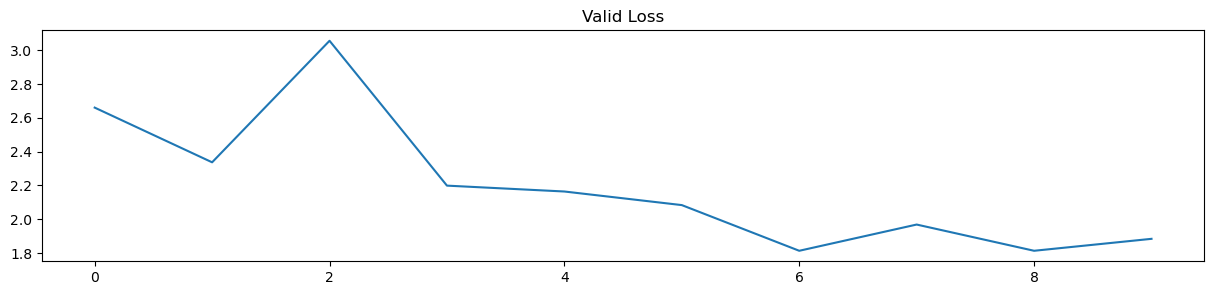

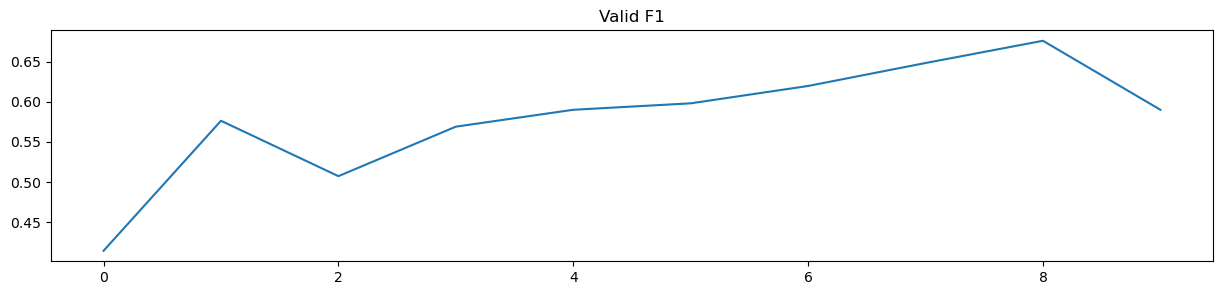

In [31]:
plt.figure(figsize=(15, 3))
plt.plot(train_accuracy_list)
plt.title('Train Accuracy')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_loss_list)
plt.title('Train Loss')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_f1_list)
plt.title('Train F1')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(valid_accuracy_list)
plt.title('Valid Accuracy')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(valid_loss_list)
plt.title('Valid Loss')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(valid_f1_list)
plt.title('Valid F1')
plt.show()

# Test

In [32]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
f1_score(total_labels, total_preds, average='macro')

0.5067319461444308

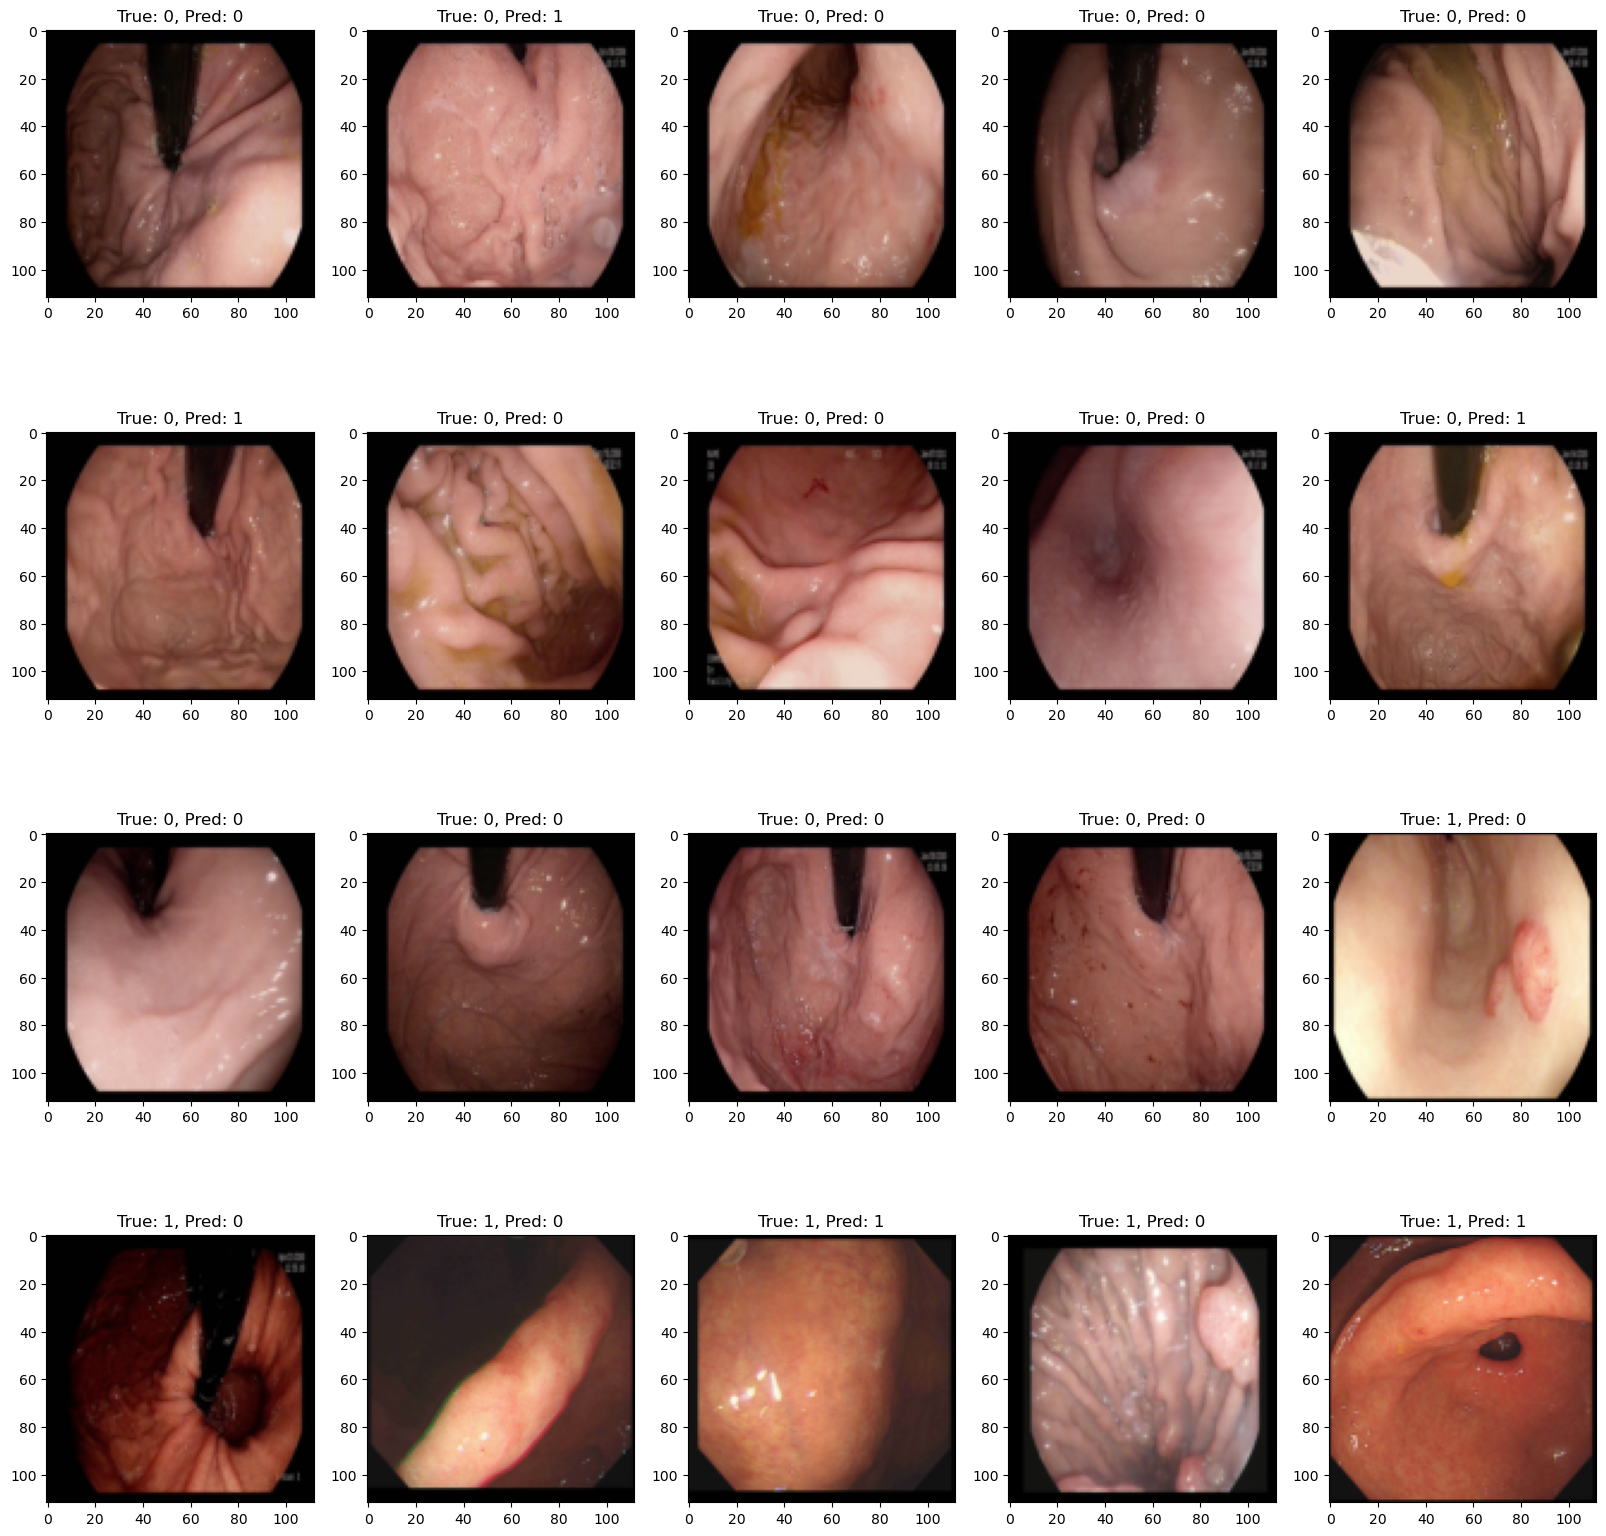

In [36]:
plt.figure(figsize=(20, 20))

for i in range(5, 25):
    ax = plt.subplot(4, 5, i-5+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}, Pred: {total_preds[i]}')